# Simulate a CBC background

This notebook is meant as a tutorial on how to use the `simulator` module within `pygwb` to simulate individual compact binary coalescences (CBC). More information about the `simulator` can be found on the documentation page [here](./_build/html/api/pygwb.simulator.html).

We start by importing some packages needed for the execution of the tutorial:

In [1]:
import numpy as np
import bilby
import matplotlib.pyplot as plt
import astropy.units as u
from pygwb.detector import Interferometer
from pygwb.network import Network
from pygwb.simulator import Simulator
%matplotlib inline

*Note: make sure to run this notebook within an environment that has all the above packages installed.*

## Injection of CBCs

For this tutorial, we consider the injection of individual CBC using the `simulator` module and `bilby`. The various steps to get to the simulated data are outlined below.

### Simulation parameters

We start by specifying the parameters that will serve as input to the simulator. Concretely, we specify the duration of each simulated segment, the number of segments, and the sampling frequency.

In [2]:
duration = 64 # duration of each segment of data (s)
N_segs = 5  # number of data segments to generate
sampling_frequency = 1024 # Hz

### Initialize empty interferometers and set a noise PSD to use in the simulation

By relying on the `detector` module, we instantiate various detectors below. For this tutorial, we decide to use the LIGO Hanford (H1) and LIGO Livingston (L1) detectors as an example. However, note that the data can be simulated for an arbitrary amount of detectors. One would simply add more detectors to the *ifo_list* below.

In [3]:
ifo_H1 = Interferometer.get_empty_interferometer('H1')
ifo_L1 = Interferometer.get_empty_interferometer('L1')

ifo_list = [ifo_H1, ifo_L1]

The above detectors are `Interferometer` objects, but are based on `bilby` detectors, which have default noise power spectral densities (PSDs) saved in them, in the `power_spectral_density` attribute of the `bilby` detector. Below, we load in this noise PSD and make sure the duration and sampling frequency of the detector is set to the desired value of these parameters chosen at the start of the notebook.

In [4]:
for ifo in ifo_list:
    ifo.duration = duration
    ifo.sampling_frequency = sampling_frequency
    ifo.power_spectral_density = bilby.gw.detector.PowerSpectralDensity(ifo.frequency_array, np.nan_to_num(ifo.power_spectral_density_array, posinf=1.e-41))

To illustrate the last few steps, we plot the PSD for the H1 detector.

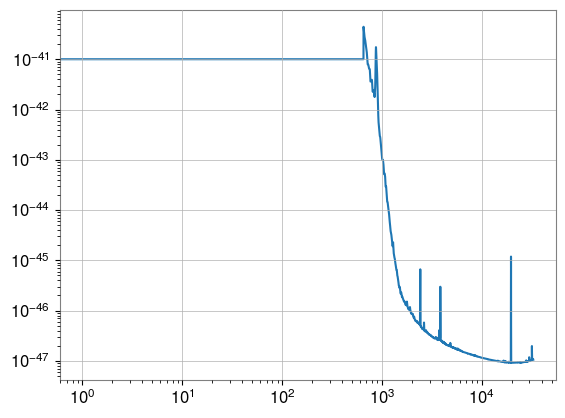

In [5]:
plt.loglog(ifo_H1.power_spectral_density.psd_array)

### Initialize a network with the interferometer list

Although the `simulator` module can be called directly, it is useful to rely on the `network` module and call the dedicated methods of that module (which calls the `simulator` behind the screens). We therefore create a network of detectors, by calling:

In [6]:
net_HL = Network('HL', ifo_list)

### Describing the CBC population used for the simulation

Before being able to simulate CBCs, we need to specify which population the CBC events are drawn from. This is done by using `bilby` priors. This allows the user to specify the distributions of the various parameters that come into play in CBC waveforms. A few examples are given below.

In [7]:
priors = bilby.gw.prior.BBHPriorDict(aligned_spin=True)
priors['chirp_mass'] = bilby.core.prior.Uniform(2, 30, name="chirp_mass")
priors['mass_ratio'] = 1.0
priors['chi_1'] = 0
priors['chi_2'] = 0
priors['luminosity_distance'] = bilby.core.prior.PowerLaw(alpha=2, name='luminosity_distance', 
                                                          minimum=10, maximum=100, 
                                                          unit='Mpc')
priors["geocent_time"] = bilby.core.prior.Uniform(0, duration*N_segs, name="geocent_time")

# create 20 injections
injections = priors.sample(20)

05:39 bilby INFO    : Using aligned spin prior
05:39 bilby INFO    : No prior given, using default BBH priors in /home/kevin.turbang/.conda/envs/pygwb_maintenance/lib/python3.9/site-packages/bilby/gw/prior_files/aligned_spins_bbh.prior.


The output of the cell above is a dictionary containing the injections, which wills erve as input for the `simulator`. It can be very useful to save these injections to file, for later use. This is done by executing the following lines of code:

In [8]:
import json

with open("injections.json", "w") as file:
    json.dump(
        injections, file, indent=2, cls=bilby.core.result.BilbyJsonEncoder
    )

### Simulate the CBCs and Gaussian noise

We are now ready to simulate the data, consisting of a CBCs and Gaussian noise, colored by the noise PSD saved in each of the detectors. We rely on the `network` module to simulate the data by calling the `set_interferometer_data_from_simulator` method (which uses the `simulator` module).

In [9]:
import logging
logging.getLogger("bilby").setLevel(logging.WARNING)

net_HL.set_interferometer_data_from_simulator(N_segs, CBC_dict=injections, sampling_frequency = sampling_frequency)

/home/kevin.turbang/.conda/envs/pygwb_maintenance/lib/python3.9/site-packages/pygwb/network.py:220: UserWarning: User did not specify a start time. Setting start time to zero.
  warnings.warn(
100%|██████████| 20/20 [00:03<00:00,  6.62it/s]
2023-05-23 05:39:43.635 | INFO     | pygwb.simulator:generate_data:272 - Adding data to channel H1:SIM-STOCH_INJ
2023-05-23 05:39:43.683 | INFO     | pygwb.simulator:generate_data:272 - Adding data to channel L1:SIM-STOCH_INJ


We show the simulated data below, illustrating that Gaussian noise and CBC injections were simulated correctly.

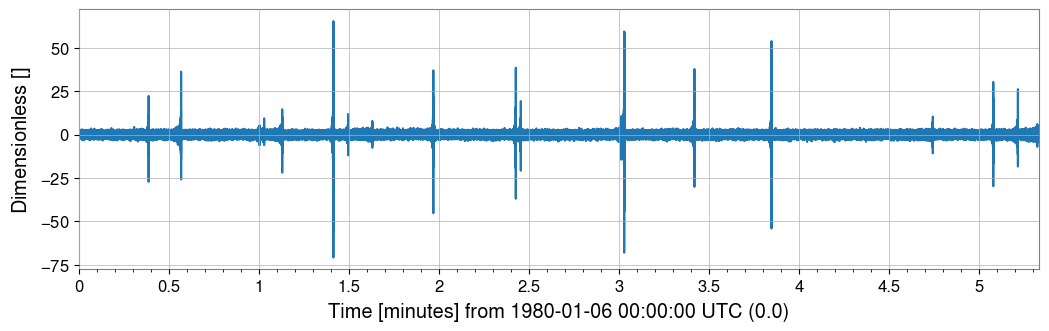

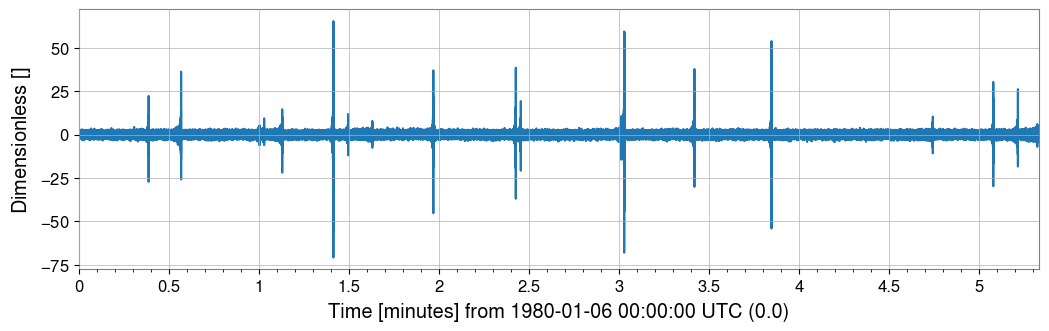

In [10]:
net_HL.interferometers[0].strain_data.to_gwpy_timeseries().whiten().plot()